# Using KNN for the Tiny Image Challenge

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Load the data

In [32]:
base_dir = 'C:/Users/doad224/Downloads/ukycs460g2019p1/';  # replace with your directory

# load features, ignore header, ignore IDs
X_train = np.loadtxt(base_dir + 'train_features.csv', delimiter=',')[:,1:];
X_test = np.loadtxt(base_dir + 'test_features.csv', delimiter=',')[:,1:];
y_train = np.loadtxt(base_dir + 'train_labels.csv', dtype=np.uint8, delimiter=',', skiprows=1)[:,-1];

In [33]:
X_train.shape, X_test.shape

((1682, 2700), (174, 2700))

In [34]:
# Get a tuple of unique values & their frequency in numpy array
uniqueValues, occurCount = np.unique(y_train, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

num_classes = len(np.unique(y_train))

Unique Values :  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
Occurrence Count :  [80 80 80 55 80 42 42 47 54 46 33 80 80 43 80 80 50 43 80 47 59 62 80 47
 69 73 70]


In [35]:
y_train_md = y_train - 1 # Class needs to start from 0.

array([20, 19, 22, ..., 11, 23, 24], dtype=uint8)

In [36]:
from sklearn.model_selection import train_test_split
xTrain, xVal, yTrain, yVal = train_test_split(X_train, 
                                              y_train_md,
                                              stratify = y_train_md,
                                              test_size = 0.15, 
                                              random_state = 0)

## Preprocessing

In [37]:
# Resize images into proper shapes

X_train_rs = X_train.reshape((-1, 30, 30, 3), order='F') 
X_test_rs = X_test.reshape((-1, 30, 30, 3), order='F')
print(X_train_rs.shape)

(1682, 30, 30, 3)


In [38]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


### Using HoG

In [39]:
# You may need to install skimage and lgbm
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
import cv2

In [40]:
# define parameter  
normalize = True  
visualize = False  
block_norm = 'L2-Hys'  
cells_per_block = [2,2]  
pixels_per_cell = [10,10]  
orientations = 9

In [41]:
def getFeat(input_data): # get and save feature values
    hog_feat = np.empty((len(input_data), 144))
    for i, image in enumerate(input_data):  
        gray = rgb2gray(image)/255.0 # trans image to gray
        fd, hog_image = hog(gray, orientations, pixels_per_cell, cells_per_block, block_norm, visualize, normalize)  
        hog_feat[i] = fd
    return hog_feat

def rgb2gray(im): # Convert to grayscale
    gray = im[:, :, 0]*0.2989+im[:, :, 1]*0.5870+im[:, :, 2]*0.1140  
    return gray 

In [42]:
# Binned color 
def bin_spatial(input_data, size=(5, 5)):
    image_spatial = np.empty((len(input_data), 75))
    for i, image in enumerate(input_data):
        bin = cv2.resize(image, size).ravel()
        image_spatial[i] = bin
    return image_spatial

In [43]:
# Color histogram 
def color_hist(input_data, nbins=5):
    color_hist_array = np.empty((len(input_data), 15))
    for i, input_image in enumerate(input_data):
        ch1 = np.histogram(input_image[:,:,0], bins = nbins, range = (0, 256))[0] # [0] is because we need only the histogram, not bins edges
        ch2 = np.histogram(input_image[:,:,1], bins = nbins, range = (0, 256))[0]
        ch3 = np.histogram(input_image[:,:,2], bins = nbins, range = (0, 256))[0]
        color_hist_array[i] = np.hstack((ch1, ch2, ch3))
    #color_hist_array = np.array(color_hist_array)
    return color_hist_array

In [44]:
def get_hog_feature(X):
    hog_feature = getFeat(X)  # HOG
    hog_bin = bin_spatial(X)
    color_hist_ = color_hist(X)
    X_hog = np.hstack((hog_feature, hog_bin, color_hist_))
    return X_hog

In [45]:
X_train_hog = get_hog_feature(X_train_rs)
X_test_hog = get_hog_feature(X_test_rs)

C:\Users\doad224\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [46]:
# Standardize
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train_new = sc.fit_transform(X_train_hog)

In [47]:
X_test_new = sc.transform(X_test_hog)

In [48]:
conda install keras

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


## Using CNN Classifier

In [49]:
from tensorflow import keras
import tensorflow
from functools import partial
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow.keras import backend

Using TensorFlow backend.


In [50]:
model = keras.models.Sequential()
#model.add(Conv2D(filters = 32, kernel_size = (3, 3),input_shape = (64, 64, 3),activation = 'relu'))
model.add(keras.layers.Dense(100, input_dim=234, kernel_initializer='uniform', activation='relu'))
#model.add(Flatten())
model.add(keras.layers.Dense(50, kernel_initializer='normal', activation='relu'))
model.add(keras.layers.Dense(27, kernel_initializer='normal', activation='softmax'))
# Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
# Had to do statified spliting cos of the imbalance in classes
from sklearn.model_selection import train_test_split
xTrain, xVal, yTrain, yVal = train_test_split(X_train_new, 
                                              y_train_md,
                                              stratify = y_train_md,
                                              test_size = 0.15, 
                                              random_state = 0)

In [52]:
history = model.fit(xTrain, yTrain, batch_size=16, epochs=500, validation_data=(xVal, yVal))

Train on 1429 samples, validate on 253 samples
Epoch 1/500
1429/1429 [==============================] - 1s 395us/sample - loss: 3.2562 - accuracy: 0.0882 - val_loss: 3.1638 - val_accuracy: 0.1897
Epoch 2/500
1429/1429 [==============================] - 0s 71us/sample - loss: 2.9624 - accuracy: 0.2127 - val_loss: 2.7005 - val_accuracy: 0.2253
Epoch 3/500
1429/1429 [==============================] - 0s 69us/sample - loss: 2.5025 - accuracy: 0.2925 - val_loss: 2.3723 - val_accuracy: 0.3043
Epoch 4/500
1429/1429 [==============================] - 0s 65us/sample - loss: 2.2795 - accuracy: 0.3422 - val_loss: 2.2035 - val_accuracy: 0.3518
Epoch 5/500
1429/1429 [==============================] - 0s 67us/sample - loss: 2.1415 - accuracy: 0.3751 - val_loss: 2.0772 - val_accuracy: 0.3794
Epoch 6/500
1429/1429 [==============================] - 0s 69us/sample - loss: 2.0231 - accuracy: 0.4108 - val_loss: 2.0029 - val_accuracy: 0.3794
Epoch 7/500
1429/1429 [==============================] - 0s 69us

Epoch 56/500
1429/1429 [==============================] - 0s 72us/sample - loss: 0.5561 - accuracy: 0.8341 - val_loss: 1.8940 - val_accuracy: 0.5257
Epoch 57/500
1429/1429 [==============================] - 0s 67us/sample - loss: 0.5327 - accuracy: 0.8446 - val_loss: 1.9369 - val_accuracy: 0.4901
Epoch 58/500
1429/1429 [==============================] - 0s 69us/sample - loss: 0.5300 - accuracy: 0.8328 - val_loss: 1.8871 - val_accuracy: 0.5534
Epoch 59/500
1429/1429 [==============================] - 0s 72us/sample - loss: 0.5063 - accuracy: 0.8593 - val_loss: 1.8996 - val_accuracy: 0.5336
Epoch 60/500
1429/1429 [==============================] - 0s 68us/sample - loss: 0.5004 - accuracy: 0.8544 - val_loss: 1.9677 - val_accuracy: 0.5336
Epoch 61/500
1429/1429 [==============================] - 0s 69us/sample - loss: 0.5253 - accuracy: 0.8411 - val_loss: 1.9573 - val_accuracy: 0.5494
Epoch 62/500
1429/1429 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.87 - 0s 69u

1429/1429 [==============================] - 0s 73us/sample - loss: 0.1001 - accuracy: 0.9839 - val_loss: 3.0900 - val_accuracy: 0.5336
Epoch 111/500
1429/1429 [==============================] - 0s 74us/sample - loss: 0.0985 - accuracy: 0.9867 - val_loss: 3.1078 - val_accuracy: 0.5455
Epoch 112/500
1429/1429 [==============================] - 0s 74us/sample - loss: 0.0861 - accuracy: 0.9874 - val_loss: 3.1016 - val_accuracy: 0.5415
Epoch 113/500
1429/1429 [==============================] - 0s 71us/sample - loss: 0.0807 - accuracy: 0.9937 - val_loss: 3.1471 - val_accuracy: 0.5336
Epoch 114/500
1429/1429 [==============================] - 0s 71us/sample - loss: 0.0843 - accuracy: 0.9888 - val_loss: 3.1749 - val_accuracy: 0.5217
Epoch 115/500
1429/1429 [==============================] - 0s 69us/sample - loss: 0.0833 - accuracy: 0.9888 - val_loss: 3.2700 - val_accuracy: 0.5375
Epoch 116/500
1429/1429 [==============================] - 0s 66us/sample - loss: 0.0706 - accuracy: 0.9944 - val_

Epoch 165/500
1429/1429 [==============================] - 0s 69us/sample - loss: 0.0073 - accuracy: 1.0000 - val_loss: 4.3424 - val_accuracy: 0.5217
Epoch 166/500
1429/1429 [==============================] - 0s 68us/sample - loss: 0.0071 - accuracy: 1.0000 - val_loss: 4.3179 - val_accuracy: 0.5217
Epoch 167/500
1429/1429 [==============================] - 0s 69us/sample - loss: 0.0068 - accuracy: 1.0000 - val_loss: 4.3538 - val_accuracy: 0.5296
Epoch 168/500
1429/1429 [==============================] - 0s 71us/sample - loss: 0.0064 - accuracy: 1.0000 - val_loss: 4.4018 - val_accuracy: 0.5138
Epoch 169/500
1429/1429 [==============================] - 0s 70us/sample - loss: 0.0061 - accuracy: 1.0000 - val_loss: 4.4194 - val_accuracy: 0.5178
Epoch 170/500
1429/1429 [==============================] - 0s 68us/sample - loss: 0.0059 - accuracy: 1.0000 - val_loss: 4.4247 - val_accuracy: 0.5217
Epoch 171/500
1429/1429 [==============================] - 0s 74us/sample - loss: 0.0057 - accuracy:

1429/1429 [==============================] - 0s 71us/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.3684 - val_accuracy: 0.5217
Epoch 220/500
1429/1429 [==============================] - 0s 65us/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.4171 - val_accuracy: 0.5336
Epoch 221/500
1429/1429 [==============================] - 0s 67us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 5.4327 - val_accuracy: 0.5178
Epoch 222/500
1429/1429 [==============================] - 0s 72us/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.5057 - val_accuracy: 0.5178
Epoch 223/500
1429/1429 [==============================] - 0s 71us/sample - loss: 9.5474e-04 - accuracy: 1.0000 - val_loss: 5.5716 - val_accuracy: 0.5217
Epoch 224/500
1429/1429 [==============================] - 0s 70us/sample - loss: 8.8776e-04 - accuracy: 1.0000 - val_loss: 5.5482 - val_accuracy: 0.5059
Epoch 225/500
1429/1429 [==============================] - 0s 69us/sample - loss: 8.1948e-04 - accuracy: 1

1429/1429 [==============================] - 0s 72us/sample - loss: 6.2764e-04 - accuracy: 1.0000 - val_loss: 5.6749 - val_accuracy: 0.5217
Epoch 274/500
1429/1429 [==============================] - 0s 70us/sample - loss: 6.1074e-04 - accuracy: 1.0000 - val_loss: 5.6988 - val_accuracy: 0.5217
Epoch 275/500
1429/1429 [==============================] - 0s 70us/sample - loss: 5.9779e-04 - accuracy: 1.0000 - val_loss: 5.7022 - val_accuracy: 0.5257
Epoch 276/500
1429/1429 [==============================] - 0s 68us/sample - loss: 5.8009e-04 - accuracy: 1.0000 - val_loss: 5.7078 - val_accuracy: 0.5217
Epoch 277/500
1429/1429 [==============================] - 0s 71us/sample - loss: 5.8186e-04 - accuracy: 1.0000 - val_loss: 5.7157 - val_accuracy: 0.5257
Epoch 278/500
1429/1429 [==============================] - 0s 71us/sample - loss: 5.5843e-04 - accuracy: 1.0000 - val_loss: 5.7521 - val_accuracy: 0.5217
Epoch 279/500
1429/1429 [==============================] - 0s 69us/sample - loss: 5.4245e-

1429/1429 [==============================] - 0s 73us/sample - loss: 1.4609e-04 - accuracy: 1.0000 - val_loss: 6.5114 - val_accuracy: 0.5375
Epoch 327/500
1429/1429 [==============================] - 0s 68us/sample - loss: 1.4358e-04 - accuracy: 1.0000 - val_loss: 6.4974 - val_accuracy: 0.5415
Epoch 328/500
1429/1429 [==============================] - 0s 71us/sample - loss: 1.3212e-04 - accuracy: 1.0000 - val_loss: 6.5196 - val_accuracy: 0.5336
Epoch 329/500
1429/1429 [==============================] - 0s 69us/sample - loss: 1.2940e-04 - accuracy: 1.0000 - val_loss: 6.5255 - val_accuracy: 0.5415
Epoch 330/500
1429/1429 [==============================] - 0s 68us/sample - loss: 1.2404e-04 - accuracy: 1.0000 - val_loss: 6.5527 - val_accuracy: 0.5336
Epoch 331/500
1429/1429 [==============================] - 0s 69us/sample - loss: 1.2239e-04 - accuracy: 1.0000 - val_loss: 6.5760 - val_accuracy: 0.5336
Epoch 332/500
1429/1429 [==============================] - 0s 68us/sample - loss: 1.1447e-

1429/1429 [==============================] - 0s 70us/sample - loss: 2.0379e-04 - accuracy: 1.0000 - val_loss: 6.6300 - val_accuracy: 0.5415
Epoch 380/500
1429/1429 [==============================] - 0s 68us/sample - loss: 1.9844e-04 - accuracy: 1.0000 - val_loss: 6.6330 - val_accuracy: 0.5415
Epoch 381/500
1429/1429 [==============================] - 0s 70us/sample - loss: 1.9239e-04 - accuracy: 1.0000 - val_loss: 6.6379 - val_accuracy: 0.5415
Epoch 382/500
1429/1429 [==============================] - 0s 69us/sample - loss: 1.8782e-04 - accuracy: 1.0000 - val_loss: 6.6447 - val_accuracy: 0.5415
Epoch 383/500
1429/1429 [==============================] - 0s 68us/sample - loss: 1.8298e-04 - accuracy: 1.0000 - val_loss: 6.6455 - val_accuracy: 0.5375
Epoch 384/500
1429/1429 [==============================] - 0s 68us/sample - loss: 1.7870e-04 - accuracy: 1.0000 - val_loss: 6.6570 - val_accuracy: 0.5415
Epoch 385/500
1429/1429 [==============================] - 0s 70us/sample - loss: 1.7439e-

1429/1429 [==============================] - 0s 74us/sample - loss: 5.8720e-05 - accuracy: 1.0000 - val_loss: 6.9844 - val_accuracy: 0.5375
Epoch 433/500
1429/1429 [==============================] - 0s 73us/sample - loss: 5.7291e-05 - accuracy: 1.0000 - val_loss: 6.9940 - val_accuracy: 0.5455
Epoch 434/500
1429/1429 [==============================] - 0s 67us/sample - loss: 5.5737e-05 - accuracy: 1.0000 - val_loss: 7.0087 - val_accuracy: 0.5375
Epoch 435/500
1429/1429 [==============================] - 0s 68us/sample - loss: 5.4800e-05 - accuracy: 1.0000 - val_loss: 7.0230 - val_accuracy: 0.5455
Epoch 436/500
1429/1429 [==============================] - 0s 68us/sample - loss: 5.4056e-05 - accuracy: 1.0000 - val_loss: 7.0238 - val_accuracy: 0.5375
Epoch 437/500
1429/1429 [==============================] - 0s 73us/sample - loss: 5.2716e-05 - accuracy: 1.0000 - val_loss: 7.0369 - val_accuracy: 0.5375
Epoch 438/500
1429/1429 [==============================] - 0s 69us/sample - loss: 5.1072e-

Epoch 485/500
1429/1429 [==============================] - 0s 68us/sample - loss: 1.4548e-05 - accuracy: 1.0000 - val_loss: 7.6575 - val_accuracy: 0.5415
Epoch 486/500
1429/1429 [==============================] - 0s 70us/sample - loss: 1.3951e-05 - accuracy: 1.0000 - val_loss: 7.6712 - val_accuracy: 0.5415
Epoch 487/500
1429/1429 [==============================] - 0s 70us/sample - loss: 1.3597e-05 - accuracy: 1.0000 - val_loss: 7.6816 - val_accuracy: 0.5494
Epoch 488/500
1429/1429 [==============================] - 0s 70us/sample - loss: 1.3144e-05 - accuracy: 1.0000 - val_loss: 7.7723 - val_accuracy: 0.5336
Epoch 489/500
1429/1429 [==============================] - 0s 69us/sample - loss: 1.3405e-05 - accuracy: 1.0000 - val_loss: 7.7458 - val_accuracy: 0.5375
Epoch 490/500
1429/1429 [==============================] - 0s 70us/sample - loss: 1.2659e-05 - accuracy: 1.0000 - val_loss: 7.7624 - val_accuracy: 0.5375
Epoch 491/500
1429/1429 [==============================] - 0s 68us/sample - 

In [53]:
history

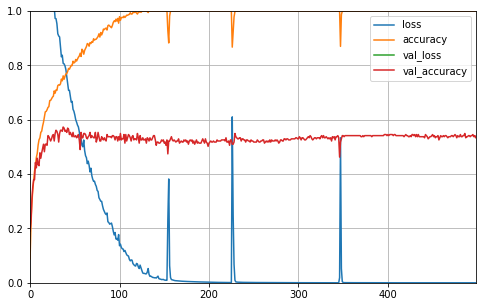

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
y_pred=model.predict_classes(xVal)
cm = confusion_matrix(yVal, y_pred) 
cm

array([[11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  1,  1,  0,  1,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  3,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  2,  1,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  1,
         1,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0],


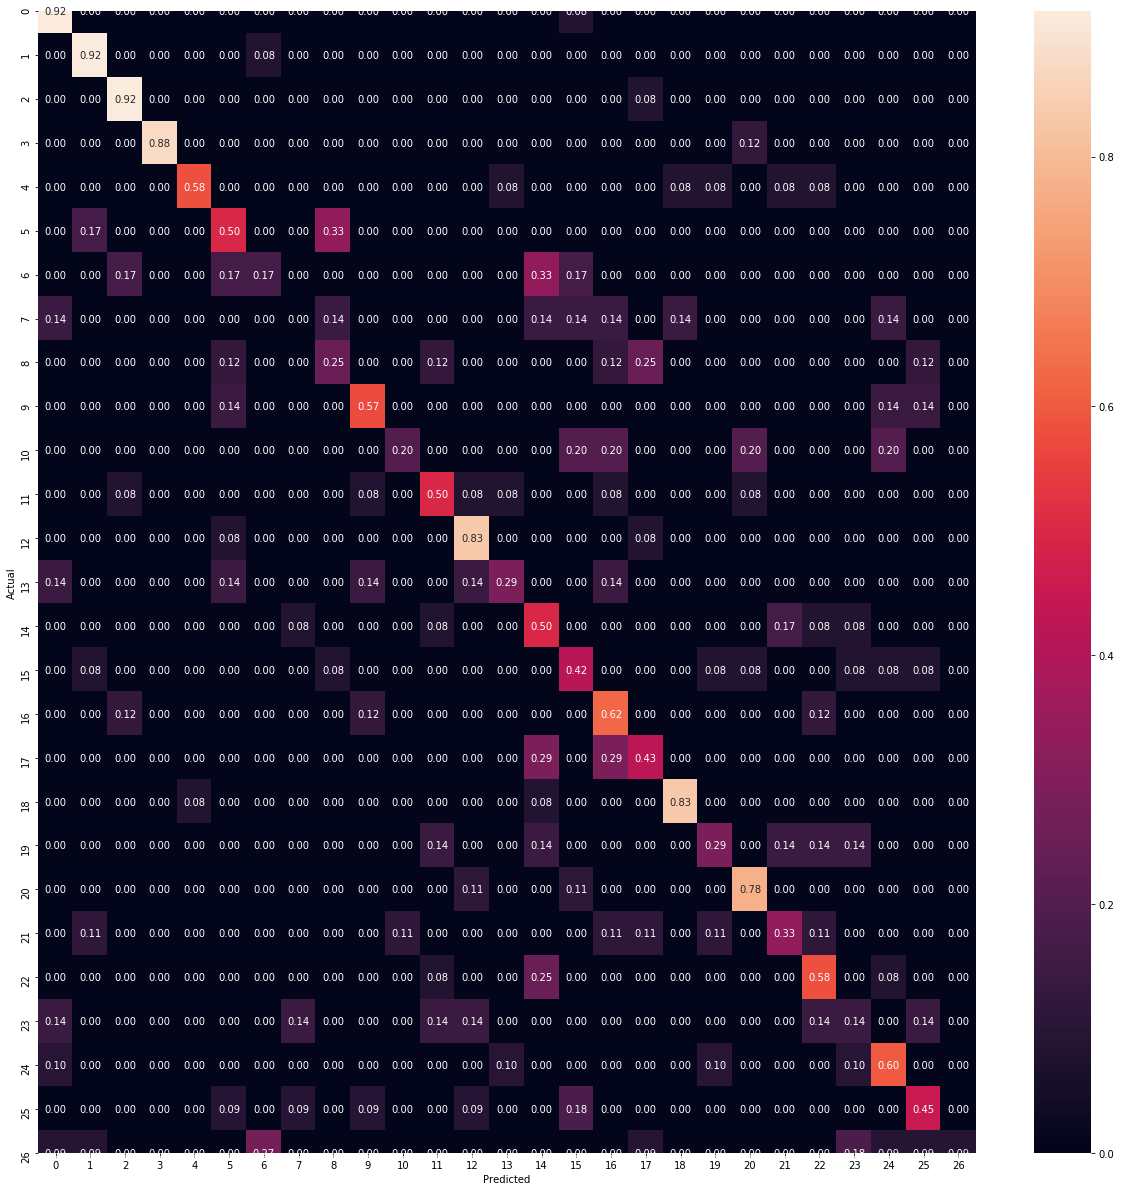

In [84]:
import seaborn as sns
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(21,21))
sns_plot=sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
fig = sns_plot.get_figure()
fig.savefig("output.png")

In [20]:
#clf=RandomForestClassifier(min_samples_leaf=4, min_samples_split=10, n_estimators=600, max_depth=90, bootstrap=False)
#clf.fit(X_train, y_train)
df = pd.DataFrame(model.predict_classes(X_test_new), columns=['Label'])
df.index += 1 # "upgrade" to one-based indexing
df.to_csv('cnn_submission.csv',index_label='ID',columns=['Label'])

## Using LGBM

In [20]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':27,
    'metric': 'multi_logloss',
    'learning_rate': 0.02296,
    'max_depth': 7,
    'num_leaves': 17,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 17}

 # making lgbm datasets for train and valid
d_train = lgbm.Dataset(xTrain, yTrain)
d_valid = lgbm.Dataset(xVal, yVal)

# training with early stop
model_lgb = lgbm.train(params, d_train, 5000, valid_sets=[d_valid], verbose_eval=50, early_stopping_rounds=10)

Training until validation scores don't improve for 10 rounds
[50]	valid_0's multi_logloss: 2.47408
[100]	valid_0's multi_logloss: 2.21483
[150]	valid_0's multi_logloss: 2.07553
[200]	valid_0's multi_logloss: 1.99518
[250]	valid_0's multi_logloss: 1.93536
[300]	valid_0's multi_logloss: 1.90744
[350]	valid_0's multi_logloss: 1.88888
[400]	valid_0's multi_logloss: 1.87699
[450]	valid_0's multi_logloss: 1.8674
Early stopping, best iteration is:
[442]	valid_0's multi_logloss: 1.8671


In [24]:
pred_prob = model_lgb.predict(xVal)

In [25]:

pred_val = np.argmax(pred_prob, axis = 1)

In [26]:

accuracy = np.sum(pred_val == yVal)/len(yVal)
accuracy

0.49407114624505927

## Cross- Validation with LGBM

In [30]:
preds = model.predict(xVal) #predictions
predictions = np.argmax(preds, axis = 1)

print(np.sum(predictions == yVal)/len(yVal))  

NameError: name 'model' is not defined